In [54]:
# upload all networks datasets, create a column year with the correct value given by its name 
import pandas as pd
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [55]:
# Define the project root and networks directory
project_root = Path("..").resolve()
networks_dir = project_root / "data" / "networks"

# Find all network CSV files
network_files = glob.glob(str(networks_dir / "networks_*.csv"))

# Initialize an empty list to store dataframes
all_networks = []

# Process each network file
for file_path in network_files:
    # Extract year from filename (networks_YYYY.csv)
    filename = os.path.basename(file_path)
    year = int(filename.split('_')[1].split('.')[0])
    
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Add year column
    df['year'] = year
    
    # Append to list
    all_networks.append(df)

# Concatenate all dataframes
combined_networks = pd.concat(all_networks, ignore_index=True)

# Display basic information about the combined dataset
print(f"Combined dataset shape: {combined_networks.shape}")
print("\nDataset dtypes:")
print(combined_networks.dtypes)
print("\nFirst few rows:")
display(combined_networks.head())



Combined dataset shape: (78462, 5)

Dataset dtypes:
node_1        object
node_2        object
weighted       int64
unweighted     int64
year           int64
dtype: object

First few rows:


,node_1,node_2,weighted,unweighted,year
0,Anarchism,law,8,0,2011
1,EndlessWar,ronpaul,4,0,2011
2,Anarchism,cyberlaws,2,0,2011
3,AmericanPolitics,Israel,1,0,2011
4,Israel,LibertarianLeft,1,0,2011


In [56]:
# Calculate network statistics

# 1. Total number of unique subreddits (nodes)
unique_subreddits = set(combined_networks['node_1']).union(set(combined_networks['node_2']))
total_nodes = len(unique_subreddits)

# 2. Total number of unique interactions (edges)
# Create a set of tuples representing unique edges (regardless of direction)
unique_edges = set()
for _, row in combined_networks.iterrows():
    # Sort the node names to treat (A,B) and (B,A) as the same edge
    edge = tuple(sorted([row['node_1'], row['node_2']]))
    unique_edges.add(edge)

total_edges = len(unique_edges)

# Display the results
print(f"Total number of unique subreddits (nodes): {total_nodes}")
print(f"Total number of unique interactions (edges): {total_edges}")

# Additional statistics by year
yearly_stats = combined_networks.groupby('year').apply(
    lambda x: pd.Series({
        'nodes': len(set(x['node_1']).union(set(x['node_2']))),
        'edges': len(set(tuple(sorted([a, b])) for a, b in zip(x['node_1'], x['node_2']))),
        'total_weight': x['weighted'].sum()
    })
)

print("\nYearly Network Statistics:")
display(yearly_stats)


Total number of unique subreddits (nodes): 600
Total number of unique interactions (edges): 39863

Yearly Network Statistics:


/var/folders/_3/7nx89wtj68x77c5zlhz5fztm0000gn/T/ipykernel_5454/2691051516.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_stats = combined_networks.groupby('year').apply(


,nodes,edges,total_weight
year,,,
2008,9,34,2081
2009,14,79,5191
2010,25,209,8140
2011,56,788,23066
2012,86,1769,44011
2013,110,2588,46098
2014,135,3386,43288
2015,170,4488,61122
2016,256,9992,252137


In [57]:
# Identify subreddits present in at least 5 consecutive years

# First, get the set of subreddits present in each year
subreddits_by_year = {}
for year, group in combined_networks.groupby('year'):
    subreddits_by_year[year] = set(group['node_1']).union(set(group['node_2']))

# Sort the years to ensure we check consecutive years
years = sorted(subreddits_by_year.keys())

# Find subreddits present in at least 5 consecutive years
persistent_subreddits = set()
for i in range(len(years) - 4):  # Need at least 5 consecutive years
    consecutive_years = years[i:i+5]
    # Find subreddits present in all these consecutive years
    subreddits_in_all = set.intersection(*[subreddits_by_year[year] for year in consecutive_years])
    persistent_subreddits.update(subreddits_in_all)

print(f"Number of subreddits present in at least 5 consecutive years: {len(persistent_subreddits)}")

# Create a filtered dataset with only these persistent subreddits
filtered_networks = combined_networks[
    (combined_networks['node_1'].isin(persistent_subreddits)) & 
    (combined_networks['node_2'].isin(persistent_subreddits))
]

print(f"\nOriginal dataset shape: {combined_networks.shape}")
print(f"Filtered dataset shape: {filtered_networks.shape}")

# Calculate the percentage of edges retained
edge_retention_pct = (filtered_networks.shape[0] / combined_networks.shape[0]) * 100
print(f"Percentage of edges retained: {edge_retention_pct:.2f}%")




Number of subreddits present in at least 5 consecutive years: 131

Original dataset shape: (78462, 5)
Filtered dataset shape: (25954, 5)
Percentage of edges retained: 33.08%


In [58]:

# Calculate the total connections (weight) per subreddit
print("\nAnalyzing subreddit connection weights:")

# Create a dictionary to store the total weight for each subreddit
subreddit_weights = {}

# Process node_1 weights
node1_weights = filtered_networks.groupby('node_1')['weighted'].sum()
for subreddit, weight in node1_weights.items():
    subreddit_weights[subreddit] = subreddit_weights.get(subreddit, 0) + weight

# Process node_2 weights
node2_weights = filtered_networks.groupby('node_2')['weighted'].sum()
for subreddit, weight in node2_weights.items():
    subreddit_weights[subreddit] = subreddit_weights.get(subreddit, 0) + weight

# Convert to DataFrame for easier analysis
subreddit_weight_df = pd.DataFrame({
    'subreddit': list(subreddit_weights.keys()),
    'total_weight': list(subreddit_weights.values())
}).sort_values('total_weight', ascending=False)

# Calculate mean weight per subreddit
mean_weight = subreddit_weight_df['total_weight'].mean()
print(f"Mean connection weight per subreddit: {mean_weight:.2f}")

# Display the top 10 subreddits by total connection weight
print("\nTop 10 subreddits by total connection weight:")
display(subreddit_weight_df.head(10))


Analyzing subreddit connection weights:
Mean connection weight per subreddit: 11886.75

Top 10 subreddits by total connection weight:


,subreddit,total_weight
110,politics,355332
63,The_Donald,94762
40,Libertarian,92727
50,PoliticalHumor,87068
49,PoliticalDiscussion,69968
54,SandersForPresident,59353
24,Economics,56826
130,worldpolitics,52933
18,Conservative,50693
65,TrueReddit,46992


In [59]:
# Analyze subreddit connections with unweighted = 1
print("\nAnalyzing subreddit connection weights (unweighted = 1 only):")

# Filter for connections where unweighted = 1
unweighted_networks = filtered_networks[filtered_networks['unweighted'] == 1]

# Create a dictionary to store the total weight for each subreddit
unweighted_subreddit_weights = {}

# Process node_1 weights
unweighted_node1_weights = unweighted_networks.groupby('node_1')['weighted'].sum()
for subreddit, weight in unweighted_node1_weights.items():
    unweighted_subreddit_weights[subreddit] = unweighted_subreddit_weights.get(subreddit, 0) + weight

# Process node_2 weights
unweighted_node2_weights = unweighted_networks.groupby('node_2')['weighted'].sum()
for subreddit, weight in unweighted_node2_weights.items():
    unweighted_subreddit_weights[subreddit] = unweighted_subreddit_weights.get(subreddit, 0) + weight

# Convert to DataFrame for easier analysis
unweighted_subreddit_weight_df = pd.DataFrame({
    'subreddit': list(unweighted_subreddit_weights.keys()),
    'total_weight': list(unweighted_subreddit_weights.values())
}).sort_values('total_weight', ascending=False)

# Calculate mean weight per subreddit
unweighted_mean_weight = unweighted_subreddit_weight_df['total_weight'].mean()
print(f"Mean connection weight per subreddit (unweighted = 1): {unweighted_mean_weight:.2f}")

# Load subreddit metadata
import json

# Load the metadata
subreddit_metadata = {}
with open('/Users/ldr0/Documents/KTH/Data Mining/FinalProject/data/metadata/subreddits_metadata.json', 'r') as f:
    for line in f:
        if line.strip():  # Skip empty lines
            data = json.loads(line)
            subreddit_metadata[data['subreddit']] = data

# Display the top 10 subreddits by total connection weight with metadata
print("\nTop 10 subreddits by total connection weight (unweighted = 1):")
top_10_with_metadata = unweighted_subreddit_weight_df.head(10).copy()

# Add metadata columns
top_10_with_metadata['party'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('party', ''))
top_10_with_metadata['banned'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('banned', 0))
top_10_with_metadata['meta'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('meta', 0))
top_10_with_metadata['gun'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('gun', 0))
top_10_with_metadata['politician'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('politician', 0))

display(top_10_with_metadata)



Analyzing subreddit connection weights (unweighted = 1 only):
Mean connection weight per subreddit (unweighted = 1): 6986.52

Top 10 subreddits by total connection weight (unweighted = 1):


,subreddit,total_weight,party,banned,meta,gun,politician
108,politics,275623,,0,0,0,0
63,The_Donald,63989,rep,1,0,0,1
40,Libertarian,55377,,0,0,0,0
50,PoliticalHumor,53635,,0,0,0,0
49,PoliticalDiscussion,37229,,0,0,0,0
24,Economics,36317,,0,0,0,0
18,Conservative,34394,,0,0,0,0
54,SandersForPresident,32441,dem,0,0,0,1
130,worldpolitics,32358,,0,0,0,0
65,TrueReddit,28256,,0,0,0,0


In [ ]:
# Analyze subreddit connections with unweighted = 1
print("\nAnalyzing subreddit connection weights (unweighted = 1 only):")

# Filter for connections where unweighted = 1
unweighted_networks = filtered_networks[filtered_networks['unweighted'] == 1]

# Create a dictionary to store the total weight for each subreddit
unweighted_subreddit_weights = {}

# Process node_1 weights
unweighted_node1_weights = unweighted_networks.groupby('node_1')['weighted'].sum()
for subreddit, weight in unweighted_node1_weights.items():
    unweighted_subreddit_weights[subreddit] = unweighted_subreddit_weights.get(subreddit, 0) + weight

# Process node_2 weights
unweighted_node2_weights = unweighted_networks.groupby('node_2')['weighted'].sum()
for subreddit, weight in unweighted_node2_weights.items():
    unweighted_subreddit_weights[subreddit] = unweighted_subreddit_weights.get(subreddit, 0) + weight

# Convert to DataFrame for easier analysis
unweighted_subreddit_weight_df = pd.DataFrame({
    'subreddit': list(unweighted_subreddit_weights.keys()),
    'total_weight': list(unweighted_subreddit_weights.values())
}).sort_values('total_weight', ascending=False)

# Calculate mean weight per subreddit
unweighted_mean_weight = unweighted_subreddit_weight_df['total_weight'].mean()
print(f"Mean connection weight per subreddit (unweighted = 1): {unweighted_mean_weight:.2f}")

# Load subreddit metadata
import json

# Load the metadata
subreddit_metadata = {}
with open('/Users/ldr0/Documents/KTH/Data Mining/FinalProject/data/metadata/subreddits_metadata.json', 'r') as f:
    for line in f:
        if line.strip():  # Skip empty lines
            data = json.loads(line)
            subreddit_metadata[data['subreddit']] = data

# Display the top 10 subreddits by total connection weight with metadata
print("\nTop 10 subreddits by total connection weight (unweighted = 1):")
top_10_with_metadata = unweighted_subreddit_weight_df.head(10).copy()

# Add metadata columns
top_10_with_metadata['party'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('party', ''))
top_10_with_metadata['banned'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('banned', 0))
top_10_with_metadata['meta'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('meta', 0))
top_10_with_metadata['gun'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('gun', 0))
top_10_with_metadata['politician'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('politician', 0))

display(top_10_with_metadata)



Analyzing subreddit connection weights (unweighted = 1 only):
Mean connection weight per subreddit (unweighted = 1): 6986.52

Top 10 subreddits by total connection weight (unweighted = 1):


,subreddit,total_weight,party,banned,meta,gun,politician
108,politics,275623,,0,0,0,0
63,The_Donald,63989,rep,1,0,0,1
40,Libertarian,55377,,0,0,0,0
50,PoliticalHumor,53635,,0,0,0,0
49,PoliticalDiscussion,37229,,0,0,0,0
24,Economics,36317,,0,0,0,0
18,Conservative,34394,,0,0,0,0
54,SandersForPresident,32441,dem,0,0,0,1
130,worldpolitics,32358,,0,0,0,0
65,TrueReddit,28256,,0,0,0,0


In [ ]:
# Analyze subreddit connections with unweighted = 1
print("\nAnalyzing subreddit connection weights (unweighted = 1 only):")

# Filter for connections where unweighted = 1
unweighted_networks = filtered_networks[filtered_networks['unweighted'] == 1]

# Create a dictionary to store the total weight for each subreddit
unweighted_subreddit_weights = {}

# Process node_1 weights
unweighted_node1_weights = unweighted_networks.groupby('node_1')['weighted'].sum()
for subreddit, weight in unweighted_node1_weights.items():
    unweighted_subreddit_weights[subreddit] = unweighted_subreddit_weights.get(subreddit, 0) + weight

# Process node_2 weights
unweighted_node2_weights = unweighted_networks.groupby('node_2')['weighted'].sum()
for subreddit, weight in unweighted_node2_weights.items():
    unweighted_subreddit_weights[subreddit] = unweighted_subreddit_weights.get(subreddit, 0) + weight

# Convert to DataFrame for easier analysis
unweighted_subreddit_weight_df = pd.DataFrame({
    'subreddit': list(unweighted_subreddit_weights.keys()),
    'total_weight': list(unweighted_subreddit_weights.values())
}).sort_values('total_weight', ascending=False)

# Calculate mean weight per subreddit
unweighted_mean_weight = unweighted_subreddit_weight_df['total_weight'].mean()
print(f"Mean connection weight per subreddit (unweighted = 1): {unweighted_mean_weight:.2f}")

# Load subreddit metadata
import json

# Load the metadata
subreddit_metadata = {}
with open('/Users/ldr0/Documents/KTH/Data Mining/FinalProject/data/metadata/subreddits_metadata.json', 'r') as f:
    for line in f:
        if line.strip():  # Skip empty lines
            data = json.loads(line)
            subreddit_metadata[data['subreddit']] = data

# Display the top 10 subreddits by total connection weight with metadata
print("\nTop 10 subreddits by total connection weight (unweighted = 1):")
top_10_with_metadata = unweighted_subreddit_weight_df.head(10).copy()

# Add metadata columns
top_10_with_metadata['party'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('party', ''))
top_10_with_metadata['banned'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('banned', 0))
top_10_with_metadata['meta'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('meta', 0))
top_10_with_metadata['gun'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('gun', 0))
top_10_with_metadata['politician'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('politician', 0))

display(top_10_with_metadata)



Analyzing subreddit connection weights (unweighted = 1 only):
Mean connection weight per subreddit (unweighted = 1): 6986.52

Top 10 subreddits by total connection weight (unweighted = 1):


,subreddit,total_weight,party,banned,meta,gun,politician
108,politics,275623,,0,0,0,0
63,The_Donald,63989,rep,1,0,0,1
40,Libertarian,55377,,0,0,0,0
50,PoliticalHumor,53635,,0,0,0,0
49,PoliticalDiscussion,37229,,0,0,0,0
24,Economics,36317,,0,0,0,0
18,Conservative,34394,,0,0,0,0
54,SandersForPresident,32441,dem,0,0,0,1
130,worldpolitics,32358,,0,0,0,0
65,TrueReddit,28256,,0,0,0,0


In [ ]:
# Analyze subreddit connections with unweighted = 1
print("\nAnalyzing subreddit connection weights (unweighted = 1 only):")

# Filter for connections where unweighted = 1
unweighted_networks = filtered_networks[filtered_networks['unweighted'] == 1]

# Create a dictionary to store the total weight for each subreddit
unweighted_subreddit_weights = {}

# Process node_1 weights
unweighted_node1_weights = unweighted_networks.groupby('node_1')['weighted'].sum()
for subreddit, weight in unweighted_node1_weights.items():
    unweighted_subreddit_weights[subreddit] = unweighted_subreddit_weights.get(subreddit, 0) + weight

# Process node_2 weights
unweighted_node2_weights = unweighted_networks.groupby('node_2')['weighted'].sum()
for subreddit, weight in unweighted_node2_weights.items():
    unweighted_subreddit_weights[subreddit] = unweighted_subreddit_weights.get(subreddit, 0) + weight

# Convert to DataFrame for easier analysis
unweighted_subreddit_weight_df = pd.DataFrame({
    'subreddit': list(unweighted_subreddit_weights.keys()),
    'total_weight': list(unweighted_subreddit_weights.values())
}).sort_values('total_weight', ascending=False)

# Calculate mean weight per subreddit
unweighted_mean_weight = unweighted_subreddit_weight_df['total_weight'].mean()
print(f"Mean connection weight per subreddit (unweighted = 1): {unweighted_mean_weight:.2f}")

# Load subreddit metadata
import json

# Load the metadata
subreddit_metadata = {}
with open('/Users/ldr0/Documents/KTH/Data Mining/FinalProject/data/metadata/subreddits_metadata.json', 'r') as f:
    for line in f:
        if line.strip():  # Skip empty lines
            data = json.loads(line)
            subreddit_metadata[data['subreddit']] = data

# Display the top 10 subreddits by total connection weight with metadata
print("\nTop 10 subreddits by total connection weight (unweighted = 1):")
top_10_with_metadata = unweighted_subreddit_weight_df.head(10).copy()

# Add metadata columns
top_10_with_metadata['party'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('party', ''))
top_10_with_metadata['banned'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('banned', 0))
top_10_with_metadata['meta'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('meta', 0))
top_10_with_metadata['gun'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('gun', 0))
top_10_with_metadata['politician'] = top_10_with_metadata['subreddit'].apply(
    lambda x: subreddit_metadata.get(x, {}).get('politician', 0))

display(top_10_with_metadata)



Analyzing subreddit connection weights (unweighted = 1 only):
Mean connection weight per subreddit (unweighted = 1): 6986.52

Top 10 subreddits by total connection weight (unweighted = 1):


,subreddit,total_weight,party,banned,meta,gun,politician
108,politics,275623,,0,0,0,0
63,The_Donald,63989,rep,1,0,0,1
40,Libertarian,55377,,0,0,0,0
50,PoliticalHumor,53635,,0,0,0,0
49,PoliticalDiscussion,37229,,0,0,0,0
24,Economics,36317,,0,0,0,0
18,Conservative,34394,,0,0,0,0
54,SandersForPresident,32441,dem,0,0,0,1
130,worldpolitics,32358,,0,0,0,0
65,TrueReddit,28256,,0,0,0,0



Analyzing evolution of top 10 subreddits' weights over time (unweighted = 1 only):


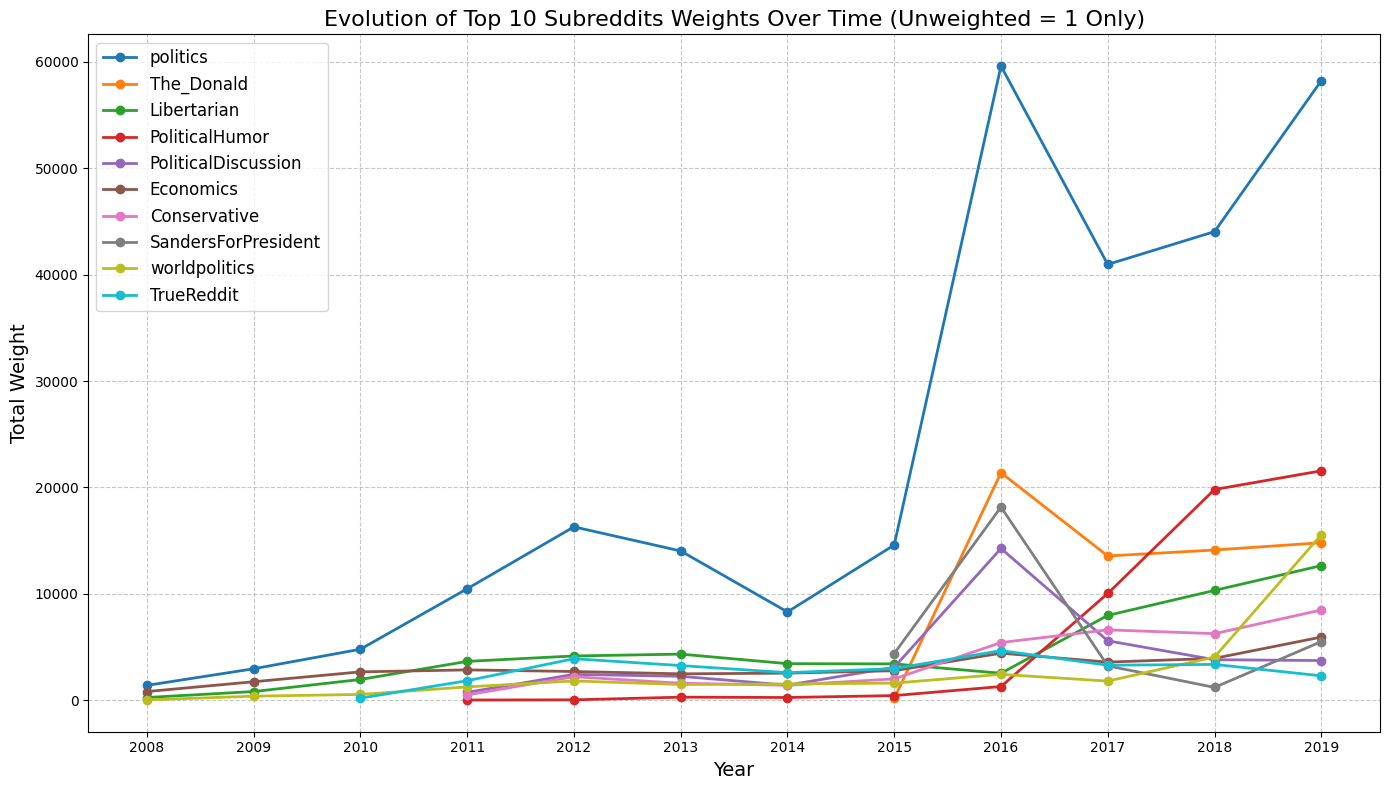

In [60]:
# Analyze the evolution of top 10 subreddits' weights over time (unweighted = 1 only)
print("\nAnalyzing evolution of top 10 subreddits' weights over time (unweighted = 1 only):")

# Get the top 10 subreddits from the previous analysis
top_10_subreddits = unweighted_subreddit_weight_df.head(10)['subreddit'].tolist()

# Filter the combined networks for unweighted = 1 and top 10 subreddits
top_subreddits_by_year = unweighted_networks[
    (unweighted_networks['node_1'].isin(top_10_subreddits)) | 
    (unweighted_networks['node_2'].isin(top_10_subreddits))
]

# Create a DataFrame to store yearly weights for each subreddit
yearly_weights = pd.DataFrame()

# Process each year
for year in sorted(top_subreddits_by_year['year'].unique()):
    year_data = top_subreddits_by_year[top_subreddits_by_year['year'] == year]
    
    # Calculate weights for each subreddit in this year
    subreddit_weights = {}
    
    # Process node_1 weights
    node1_weights = year_data.groupby('node_1')['weighted'].sum()
    for subreddit, weight in node1_weights.items():
        if subreddit in top_10_subreddits:
            subreddit_weights[subreddit] = subreddit_weights.get(subreddit, 0) + weight
    
    # Process node_2 weights
    node2_weights = year_data.groupby('node_2')['weighted'].sum()
    for subreddit, weight in node2_weights.items():
        if subreddit in top_10_subreddits:
            subreddit_weights[subreddit] = subreddit_weights.get(subreddit, 0) + weight
    
    # Add to yearly_weights DataFrame
    year_df = pd.DataFrame(subreddit_weights, index=[year])
    yearly_weights = pd.concat([yearly_weights, year_df])

# Plot the evolution of weights for top 10 subreddits
plt.figure(figsize=(14, 8))
for subreddit in top_10_subreddits:
    plt.plot(yearly_weights.index, yearly_weights[subreddit], marker='o', linewidth=2, label=subreddit)

plt.title('Evolution of Top 10 Subreddits Weights Over Time (Unweighted = 1 Only)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Weight', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(yearly_weights.index)
plt.tight_layout()
plt.show()
